# Computational Methods in Economics

## Lecture 5b - Numerical Optimization and Data Analysis

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2020-01-07 15:19:33.132702


### Preliminaries

#### Import Modules

In [1]:
import numpy as np
import pandas as pd

np.set_printoptions(precision=4, suppress = True)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import statsmodels.api as sm

import scipy.optimize
import scipy.linalg

import IPython.display as display

## This Lecture

- [Introduction](#introduction)
- [The Scikit-Learn Package](#scikit)
- [Notation and Terminology](#not)
- [Linear Least-Squares Problems](#lls)
- [Gradient Descent](#grad)
- [ML vs. Econometrics: Regularization](#lasso)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'introduction'></a>

### Introduction

In the previous lecture we have discussed how to solve general optimization problems numerically. In this class, we are going to look at particular optimization problems that (among other applications) arise frequently in the context of data analysis.

In addition, we also introduce more functionality for Python, in particular the **scikit-learn** package.

**scikit-learn** is most commonly used in the context of "data science" and "machine learning". 

An additional goal of this class is to give a short introduction in particular to machine learning - also called "statistical learning" -, and show how it differs (and what it has in common) with more standard (from an economist's point of view) approaches to data analysis in econometrics.

Hence, we will talk about ML methods and applications analysis in more depth later in the lecture. For now, let's just briefly define what we understand as "machine learning". The two most frequently definitions are probably the following:

*[Machine Learning is] the field of study that gives computers the ability to learn without explicitly programmed. (Arthur Samuel, 1959)*

*A computer program is said to learn from experience E with respect to some task T and some performance measure P, if its performance on T, as measured by P, improves with E. (Tony Mitchell, 1997)*

The classical exam for an ML application is an email spam filter (*task T*): the algorithm takes examples of emails which are flagged as "spam" and examples of regular emails (*experience E*), and learns how to distinguish between spam and non-spam emails.

It can then *predict* whether a new email is spam or non-spam. 

In fact, (*supervised*) machine learning is not only about learning, but also about prediction: you want the computer to learn using existing data, to make predictions about new (or not-yet-seen) data. 

In this way, ML methods can be used to automate certain tasks. 

It goes without saying that given the complexity of the topic and the limited amount of time, we will not be able to go in much depth. That said, the idea is to introduce some core ideas and terminology, and leave the rest to more specialized courses.

Some of the material used in this lecture is following the excellent book **Hands-On Machine Learning with Scikit-Learn and Tensor Flow** by Aurelien Gideon. 

An excellent survey paper on the relationship between ML and econometrics and on the use of ML for economic analysis is **Machine Learning: An Applied Econometric Approach** by Sendhil Mullainathan and Jann Spiess.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'scikit'></a>

### The scikit-learn Package

scikit-learn (**sklearn**) is a very popular package for data analysis in  general and machine learning in particular. It builds on the packages we have already seen - NumPy, SciPy and Matplotlib - and provides a lot of additional functionality (of which we will only scratch the surface).

Its documentation and an extensive amount of tutorials and other material can be found here: https://scikit-learn.org/stable/index.html.

Similar to SciPy, to use **sklearn**, we import individual subpackages rather than the whole package:

In [3]:
from sklearn.datasets import load_boston
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

For now, just focus on the first statement in the cell above. scikit-learn includes a few "toy datasets" (as well as easy access to some larger "real-world" datasets), one of which we will use as a workhorse example below. It contains data on house prices and features in the Boston area. 

We load the dataset - which comes in the form of what is essentially a dictionary - and display its **DESCR** key, which contains a description.

In [4]:
boston = load_boston()
print( boston.DESCR )

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

We can check all key-value pairs in the dictionary by running the **keys()** method:

In [5]:
print( boston.keys() )

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


The data is contained in the **data** and the **target** field. We can check that the number of data points in **data** are consistent with the description:

In [6]:
print("Data shape: {}".format(boston.data.shape))

Data shape: (506, 13)


--------------------------------------------------------------------------------------------------------------------------------
<a id = 'not'></a>

### Notation and Terminology

In the following, we use the notation that is standard in data analysis, in particular econometrics and data science. While this makes it consistent with other courses that you might have taken in the past, the notation will be different compared to the previous lectures in this class.


In particular, let $(y_i, \mathbf{x}_i)$ be a given tuple of data corresponding to observation $i$. 

$y_i$ is a scalar and referred to as a dependent variable, a *label* (if it comes from a discrete set of values) or *target/outcome variable* (if it is a continuous variable).

$\mathbf{x}_i = [x_{i1}, ... , x_{in}]^T \in \mathbb{R}^n$ is a vector of dimension $n$. Each element of $\mathbf{x}_i$ is referred to as an independent variable, a *regressor* or a *feature*.

For a data set consisting of $m$ observations, $\mathbf{y} = [y_{1}, ... , y_{m}]^T  \in \mathbb{R}^m$ is a vector of outcome variables, while

\begin{equation}
    \mathbf{X} =  \left[ \begin{array}{c}
    \mathbf{x}_1^T  \\
    \vdots \\
    \mathbf{x}_m^T 
    \end{array} \right] =  
    \left[ \begin{array}{cccc}
    x_{11} & x_{12} & ... & x_{1n}  \\
    x_{21} & x_{22} & ... & x_{2n}  \\
    \vdots \\
    x_{m1} & x_{m2} & ... & x_{mn}  \\
    \end{array} \right] 
\end{equation}

is an *m*-by-*n* matrix containing all realizations of the feature variables. It is also referred to as the *regression or feature matrix*. 

In the context of our example dataset above, we define **'y'** as the vector of target variables (in **boston.target**) and **'X'** as the feature matrix containing the regressors in **boston.data**:

In [7]:
y = boston.target
X = boston.data

In [8]:
## display first five observations
print( X[:5, :])

[[  0.0063  18.       2.31     0.       0.538    6.575   65.2      4.09
    1.     296.      15.3    396.9      4.98  ]
 [  0.0273   0.       7.07     0.       0.469    6.421   78.9      4.9671
    2.     242.      17.8    396.9      9.14  ]
 [  0.0273   0.       7.07     0.       0.469    7.185   61.1      4.9671
    2.     242.      17.8    392.83     4.03  ]
 [  0.0324   0.       2.18     0.       0.458    6.998   45.8      6.0622
    3.     222.      18.7    394.63     2.94  ]
 [  0.0691   0.       2.18     0.       0.458    7.147   54.2      6.0622
    3.     222.      18.7    396.9      5.33  ]]


##### Hypothesis and Residual Function

On a very general level, when analyzing data, we compare the realizations of the target variable in the sample, $\mathbf{y}$, with a vector $\hat{\mathbf{y}} = [\hat{y}_{1}, ... , \hat{y}_{m}]^T$ of *predicted* outcomes. 

The predicted value of the target variable for observation $i$ is given by a function $h$, which (in machine learning terminology) is called the *hypothesis*. 

More precisely, the function $\hat{y}_{i} = h(\mathbf{x}_i; \mathbf{b})$ returns the prediction for the target variable $y_i$ given the feature vector $\mathbf{x}_i$ and a vector of *parameters* (or *coefficients* or *weights*) $\mathbf{b}$. 

No matter what the purpose of an empirical analysis is, e.g. causal estimation (in econometrics) or prediction (in statistical/machine learning), it usually requires determining the parameter values given a data set, $(\mathbf{y}, \mathbf{X})$. This step is done by setting it up as a minimization problem.

That is, we choose $\mathbf{b}$ by minimizing a measure of the difference between the observed values of the outcome variable and its predicted values when using the hypothesis function. 

For a single observation, this difference is called the *residual (function)*:

\begin{equation}
    h(\mathbf{x}_i; \mathbf{b})- y_i \equiv r_i(\mathbf{b}; y_i, \mathbf{x}_i) = r_i(\mathbf{b})
\end{equation}

Note the following:

- We have defined $h$ as a function of the data $\mathbf{x}_i$, given parameter values $\mathbf{b}$. In contrast, we write the residual as a function of $\mathbf{b}$. Of course, $r_i$ also depends on the data, but we usually omit these as arguments.

- Related to this, we have a *different* residual function $r_i$ for every observation $i$.

- Every $r_i$ is a scalar function, with $r_i: \mathbb{R}^n \rightarrow \mathbb{R}$.

Finally, let $\mathbf{r}$ denote the vector of residuals (i.e. a vector-valued function $\mathbb{R}^n \rightarrow \mathbb{R}^m$) across the sample:

\begin{equation}
    \mathbf{r}(\mathbf{b})  =  \left[ \begin{array}{c}
    r_1(\mathbf{b})  \\
    \vdots \\
    r_m(\mathbf{b}) 
    \end{array} \right] 
\end{equation}

#### Least-Squares Minimization

There are different alternatives with respect to how to set up the objective function $L(\mathbf{b})$ in the minimization problem to find the parameter values $\mathbf{b}$:

\begin{equation}
    \min_{\mathbf{b}} L(\mathbf{b})
\end{equation}

$L$ is also referred to as the *loss function* or *cost function*.

#####  $\mathcal{l}_\infty$-norm

Define $L$ as 

\begin{equation}
    L(\mathbf{b}) = \left| \left| \mathbf{r}(\mathbf{b}) \right| \right|_{\infty} = \max_{i = 1,...,m} \left| r_i(\mathbf{b}) \right|
\end{equation}

Hence, the loss function is determined by the data point with the largest deviation (in absolute value) from its predicted value.

#####  $\mathcal{l}_1$-norm

Define $L$ as 

\begin{equation}
    L(\mathbf{b}) = \left| \left| \mathbf{r}(\mathbf{b}) \right| \right|_{1} = \sum_{i = 1}^m \left| r_i(\mathbf{b}) \right|
\end{equation}

Hence, the loss function is the sum of absolute values of the residuals.

#####  $\mathcal{l}_2$/Euclidean norm

Define $L$ as 

\begin{equation}
    L(\mathbf{b}) = \frac{1}{2} \left(\ \left| \left|\ \mathbf{r}(\mathbf{b}) \right| \right|_{2}\ \right)^2 = \frac{1}{2}\sum_{i = 1}^m \left[r_i(\mathbf{b})\right]^2
\end{equation}


As a side note, recall that for a vector $\mathbf{v} \in \mathbb{R}^n$, the Euclidean norm is defined as 

\begin{equation}
     \left| \left|\ \mathbf{v}\ \right| \right|_2 = \left| \left|\ \mathbf{v}\ \right| \right| = \sqrt{ \sum_{j = 1}^n v_i^2} = \sqrt{ \mathbf{v}^T \mathbf{v} }
\end{equation}

Above, we use one half of the square of the norm; of course, this does not affect the result of the minimization. 

Hence, the loss function is the sum of squares of the residuals. Minimizing this function is the by far most common method for finding $\mathbf{b}$.

In other words, we set up the problem of determining $\mathbf{b}$ as a *least-squares (LS) problem*.

LS problems are an extremely important class of unconstrained optimization problems. Compared to a generic minimization problem, as discussed in the previous lecture, the special form of the objective function in 

\begin{equation}
   \min_{\mathbf{b}} L(\mathbf{b}) = \min_{\mathbf{b}} \frac{1}{2}\sum_{i = 1}^m \left[r_i(\mathbf{b})\right]^2
\end{equation}

makes LS problems easier to solve than more general problems (see below). 

Note that in machine learning, you usually divide the loss function above by the number of observations $m$. In this way, you minimze the *mean square error* (MSE):

\begin{equation}
   \min_{\mathbf{b}} MSE(\mathbf{b}) = \min_{\mathbf{b}} \frac{1}{2m}\sum_{i = 1}^m \left[r_i(\mathbf{b})\right]^2
\end{equation}

Of course, whether you use this objective or the one above does not affect the solution to your minimization problem.

Before moving on, let's recap the different types of functions defined above:
- the hypothesis function $h(\mathbf{x}_i; \mathbf{b})$ gives a prediction of the target value for data point $\mathbf{x}_i$;
- the difference between the actual and predicted value gives rise to the residual function $r_i(\mathbf{b})$;
- in LS, the loss function is defined as the sum of squared residuals; minimizing it determines $\mathbf{b}$. 


Note that the LS method imposes a functional form on $L$, but does not prescribe what $h$ (and hence $r$) looks like. If $h$ is linear in the parameters $\mathbf{b}$, the problem becomes the OLS linear regression framework that you are familiar with.

It is important to understand though that this is one particular class of LS problems. In other words, the use of LS is not restricted to linear hypothesis functions. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'lls'></a>

### Linear Least-Squares Problems

In linear LS problems, the hypothesis function is *linear in the parameters* $\mathbf{b}$ (but not necessarily linear in the features $\mathbf{x}$!).

Hence,

\begin{equation}
    \hat{y}_i = h(\mathbf{x}_i; \mathbf{b}) = b_1 x_{i1} + b_2 x_{i2} + ... + b_{n} x_{in} = \sum_{j = 1}^n b_j x_{ij} = \mathbf{x}_i^T \mathbf{b}. 
\end{equation}


Note that while this notation makes it look like all the $x_{ij}$'s are distinct features, some can be functions of the others, e.g.

\begin{equation}
    x_{i2} = x_{i1}^2. 
\end{equation}

For the whole sample, we have

\begin{equation}
    \hat{\mathbf{y}}  = \left[ \begin{array}{c}
    \hat{y}_1\\
    \vdots \\
    \hat{y}_m
    \end{array} \right]= \left[ \begin{array}{c}
    \mathbf{x}_1^T \mathbf{b} \\
    \vdots \\
    \mathbf{x}_m^T \mathbf{b}
    \end{array} \right] = \mathbf{X} \mathbf{b}
\end{equation}


Hence, in matrix notation, we can express the loss function in a number of equivalent ways:

\begin{equation}
\begin{split}
    L(\mathbf{b}) &= \frac{1}{2}\sum_{i = 1}^m \left[\hat{y}_i - y_i\right]^2 = \frac{1}{2} \ \left| \left|\ \hat{\mathbf{y}} - \mathbf{y}\ \right| \right|^2 \\
    &= \frac{1}{2} \left| \left|\ \mathbf{X} \mathbf{b} - \mathbf{y}\ \right| \right|^2 = \frac{1}{2} \left| \left|\ \begin{array}{c}
    \mathbf{x}_1^T \mathbf{b} - y_1 \\
    \vdots \\
    \mathbf{x}_m^T \mathbf{b} - y_m
    \end{array}
    \ \right| \right|^2 = \frac{1}{2} (\mathbf{X} \mathbf{b} - \mathbf{y})^T (\mathbf{X} \mathbf{b} - \mathbf{y})
\end{split}    
\end{equation}

When implementing the loss function, the last definition is computationally most efficient:

In [9]:
## define loss function
def loss(b, X):
    predicted_values = X @ b
    return 0.5 * ( predicted_values - y ).T @ ( predicted_values - y )

#### Gradient

The derivative of the loss function w.r.t. to $b_j$ is:

\begin{equation}
    \frac{\partial L}{\partial b_j} = \sum_{i = 1}^m \left[ \hat{y}_i - y_i \right] x_{ij} = \mathbf{X}_j^T \cdot (\hat{\mathbf{y} } - \mathbf{y}),
\end{equation}

where $\mathbf{X}_j$ denotes the $j$th column in the regression matrix. 

Hence, the gradient of the loss function is given by:

\begin{equation}
    \nabla L = \left[ 
        \begin{array}{c}
        \frac{\partial L}{\partial b_1} \\
        \vdots \\
        \frac{\partial L}{\partial b_m}
        \end{array}
    \right] =  \mathbf{X}^T \cdot(\hat{\mathbf{y} } - \mathbf{y}) = \mathbf{X}^T \cdot(\mathbf{X} \mathbf{b} - \mathbf{y}) 
\end{equation}.

Moreover, it is straightforward to see that the Hessian of the loss function is:

\begin{equation}
    \nabla^2 L = \left[ 
        \begin{array}{ccc}
        \frac{\partial^2 L}{\partial b_1 \partial b_1} & ... & \frac{\partial^2 L}{\partial b_1 \partial b_n} \\
        \vdots & \ddots & \vdots \\
        \frac{\partial^2 L}{\partial b_n \partial b_1} & ... & \frac{\partial^2 L}{\partial b_n \partial b_n}
        \end{array}
    \right]  = \mathbf{X}^T \mathbf{X}
\end{equation}

Two things are noteworthy here:

- the Hessian depends solely on the feature matrix $\mathbf{X}$ and is independent of $\mathbf{b}$; hence, it needs to be *computed only once*;
- it is positive definite, implying that the loss function is convex. Hence, any $\mathbf{b}^*$ such that $\nabla L(\mathbf{b}^*) = 0$ is the *global* minimizer of $L$. 

It should be emphasized that these properties are particular for linear LS problems, and do not necessarily hold for non-linear problems (and of course not for general minimization problems either)! 

As a side note, $\mathbf{X}^T \mathbf{X}$ being positive definite may not be obvious at first glance. However, you can show that for an arbitrary $m$-by-$n$ matrix $A$ with $m \ge n$ and rank $n$ - i.e., that has linearly independent columns - the matrix product $A^T A$ is positive definite. This will be shown in this week's problem set. 

Moreover, by construction, $A^T A$ is also symmetric. 

#### Normal Equations

We can use the gradient directly for computing a minimum of the loss function, by setting it equal to zero: $\nabla L  = 0$, or 

\begin{equation}
     \mathbf{X}^T \cdot(\hat{\mathbf{y} } - \mathbf{y}) = \mathbf{X}^T \cdot(\mathbf{X} \mathbf{b} - \mathbf{y}) \overset{!}{=} 0
\end{equation}

Hence, $\mathbf{b}^*$ must satisfy the following linear system of equations:

\begin{equation}
     (\mathbf{X}^T \mathbf{X}) \mathbf{b} = \mathbf{X}^T \mathbf{y}
\end{equation}

These are called the *normal equations*. Solving them gives a closed-form solution for $\mathbf{b}^*$.

Solving for $\mathbf{b}^*$ by using the inverse of $\mathbf{X}^T \mathbf{X}$ gives the familiar formula for the OLS estimator:

\begin{equation}
     \mathbf{b}^* = \left(\mathbf{X}^T \mathbf{X}\right)^{-1} \mathbf{X}^T \mathbf{y}
\end{equation}

In practice, statistical programs do not use the inverse to solve the normal equations. Instead, they rely on methods that follow the same idea as LU factorization and triangular back- and forward substitution that we have encountered in lecture 3.

Instead of LU factorization, however, the fact that $\mathbf{X}^T \mathbf{X}$ is a symmetric and positive definite matrix, as established above, allows to use *Cholesky factorization*, which requires only half the number operations compared to LU. 

In more detail, for any symmetric positive definite $n$-by-$n$ matrix $A$, Cholesky factorization produces the following decomposition:

\begin{equation}
    A = U^T U,
\end{equation}

where $U$ is an $n$-by-$n$ upper triangular matrix with positive diagonal elements. Once we have obtained $U$, we can easily apply triangular substitution.

As a side note, Cholesky factorization can be used to check if a symmetric matrix is positive definite. If the algorithm returns a matrix $U$ where the diagonal elements are well-defined and positive, positive definiteness is verified.

In SciPy, we have a function **scipy.linalg.cholesky** that returns $U$. As an example, let's use the feature matrix from our data set, perform Cholesky factorization and check the diagonal elements of $U$.

In [10]:
A = X.T @ X
print(A.shape)

(13, 13)


In [11]:
U = scipy.linalg.cholesky(A)
print( np.diag( U ) )

[ 209.6911  583.1158  247.5719    5.6853    4.2375   26.1753  402.8917
   31.227   130.701  1295.7229   49.1618 1852.0389   98.0639]


For the sake of completeness, if you try to apply Cholesky factorization on a matrix that is not positive definite, SciPy raises an error:

In [12]:
A = np.array([[1., 2.], 
              [2., 4.], 
              [3., 6.]])

print( np.linalg.matrix_rank(A) )
## this line will throw an error, since A has rank 1 < n and hence A.T @ A is not positive definite!
# print( scipy.linalg.cholesky(A.T @ A) )


1


Going back on how to solve the normal equations for $\mathbf{b}^*$, an important disadvantage of Cholesky factorization is that the condition number of $\mathbf{X}^T \mathbf{X}$ is the square of the condition number of $\mathbf{X}$. 

Recall that the higher the condition number, the less well-conditioned a matrix is, and the higher the numerical error in the computed solution.

Hence, the Cholesky-based method can result in less accurate solutions than when using methods that avoid a squaring of the condition number. When $\mathbf{X}$ is ill-conditioned, Cholesky factorization may even break down.

In addition, Cholesky will also not work if $\mathbf{X}$ is "rank-deficient", i.e. has rank less than $n$.

That's why in practice, solving the normal equations is often done by means of factorization of $\mathbf{X}$ rather than $\mathbf{X}^T \mathbf{X}$. Among the alternative approaches are *QR factorization* and *singular-value decomposition* (SVD). 

While potentially more computationally expensive, both methods approach are more robust and reliable than Cholesky, since avoid squaring the condition number. SVD also allows for rank-deficient matrices. 

While we will not go into more detail here, note that the SVD-approach is the default in SciPy's **scipy.linalg.lstsq** function for solving linear least-squares problems.  

#### Solving Linear LS Problems in Python

In Python, there are several alternative packages and functions for solving linear LS problems. We have already seen that the **statsmodels** package has a OLS routine, which is very convenient in connection with Pandas (see the tutorial on Pandas).

As mentioned above, SciPy has a function **scipy.linalg.lstsq** that returns the parameter vector $\mathbf{b}^*$ for a given feature matrix $\mathbf{X}$ and target vector $\mathbf{y}$, along with some additional information as a tuple. 

Before running the function, we add a column to our feature matrix that consists of ones. This takes care of the intercept in the linear regression problem. In other words, we assume that $x_{i1} = 1$ for all observations. 

In [13]:
X_1 = np.column_stack( (np.ones( X.shape[0] ), X ) )
print(X_1[:5, :5])

[[ 1.      0.0063 18.      2.31    0.    ]
 [ 1.      0.0273  0.      7.07    0.    ]
 [ 1.      0.0273  0.      7.07    0.    ]
 [ 1.      0.0324  0.      2.18    0.    ]
 [ 1.      0.0691  0.      2.18    0.    ]]


In [14]:
res = scipy.linalg.lstsq(X_1, y)
## print parameter values
print( res[0])

[ 36.4595  -0.108    0.0464   0.0206   2.6867 -17.7666   3.8099   0.0007
  -1.4756   0.306   -0.0123  -0.9527   0.0093  -0.5248]


Alternatively, we can set up the linear LS problem using scikit-learn's **LinearRegression()** class (which we have imported above). Note that this a "wrapper" around **scipy.linalg.lstsq**, i.e. it uses this function for the minimization, but then presents the output in a different, nicer way.

Note also that we do not have to add a column of ones to the feature matrix; this is done by default.

In [15]:
lr = LinearRegression()
lr.fit(X, y)
print("Intercept: {}".format(lr.intercept_) )
print("Coefficients: {}".format(lr.coef_) )
## store results for later comparison
b_lls = np.insert( lr.coef_, 0, lr.intercept_)

Intercept: 36.459488385089855
Coefficients: [ -0.108    0.0464   0.0206   2.6867 -17.7666   3.8099   0.0007  -1.4756
   0.306   -0.0123  -0.9527   0.0093  -0.5248]


In [16]:
## for comparison: compute b by hand, using the inverse
b = np.linalg.inv((X_1.T @ X_1)) @ X_1.T @ y
print(b)

[ 36.4595  -0.108    0.0464   0.0206   2.6867 -17.7666   3.8099   0.0007
  -1.4756   0.306   -0.0123  -0.9527   0.0093  -0.5248]


Note that this syntax is typical of scikit-learn, and we will see more examples below. We start by initiating an instance of a **LinearRegression()** class, which does not take any arguments. Solving the linear LS problem happens in the second line where we use the **fit** method, and give it the feature matrix and the target vector as inputs.

The parameter values can then be found in the **coef_** and **intercept_** attribute. 

Finally, let's emphasize once more that the closed-form solution coming from the normal equations exists only in the case of linear LS. For nonlinear LS problem, this direct approach is not (typically) available.

Moreover, there are LS problems where finding $\mathbf{b}^*$ by solving the normal equations is not the most efficient. In all these cases, we will have to resort to iterative methods once again. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'grad'></a>

### Quasi-Newton Methods: Gradient Descent

Before moving on to nonlinear LS problems, we will get to know one more algorithm for numerical optimization, *gradient descent* or *steepest descent*. 

While this is essentially a simple variant of Quasi-Newton methods and can be used to solve general optimization problems, its use is particularly common in the context of machine learning. 

As a quick recap, we have introduced the class of line search method. Recall that line search is an iterative procedure, generating a sequence of iterates $\{ x^{(k)} \}$ that are aimed to converge towards the minimum $x^*$. The update rule is

\begin{equation}
    \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \mathbf{s}^{(k)} = \mathbf{x}^{(k)} + \alpha^{(k)} \mathbf{d}^{(k)}
\end{equation}

with *search direction* $\mathbf{d}^{(k)}$ and *distance* $\alpha^{(k)}$, i.e. the length of the *step* $\mathbf{s}^{(k)}$.

On a general level, line search algorithms take the direction $\mathbf{d}^{(k)}$ as given and then choose $\alpha$ by solving the following problem:

\begin{equation}
    \min_{\alpha > 0} f(\mathbf{x}^{(k)} + \alpha \mathbf{d}^{(k)})
\end{equation}


We have also noted that different variants of line search methods differ in their choice of the search direction (and some also fix $\alpha$), and hence with respect to how to determine $\mathbf{s}^{(k)} = \alpha^{(k)} \mathbf{d}^{(k)}$. For example, Newton's method uses the following step, with a fixed $\alpha$:

\begin{equation}
 \mathbf{s}^{(k)} = \mathbf{d}^{(k)} = - H(\mathbf{x}^{(k)}) ^{-1}\nabla  f(\mathbf{x}^{(k)}) 
\end{equation}

Other than this, they all follow the same iterative procedure (which we had implemented in the function **my_opt**).

The gradient descent algorithm uses the gradient as the search direction:

\begin{equation}
  \mathbf{d}^{(k)} = - \nabla  f(\mathbf{x}^{(k)})
\end{equation}

and then looks for the optimal $\alpha^{(k)}$, for example by using Armijo search and backtracking. 

Hence, we can interpret gradient descent as a simple Quasi-Newton method, where the Hessian in the Newton-Raphson update rule is *approximated by the identity matrix*. 

Gradient descent is very intuitive: in order to minimize, we move in the direction of a local minimum. The main problem of gradient descent is that convergence is in general very slow, in particular for objective functions that are highly non-linear. 

The Rosenbrock function is good example: even when using an optimal $\alpha$ in every iteration, it can take thousands of iterations to get to the minimum. While gradient descent gets down to the Rosenbrock valley very quickly, it then makes very slow progress towards to the minimum. 

Compare http://www.benfrederickson.com/numerical-optimization/ for a visualization).

#### Gradient Descent for Linear Regression

However, gradient descent is popular in applications where the objective is more regular (say, quadratic, and hence convex) and hence the gradient is linear. 

The obvious example is linear LS problems, for whcih gradient descent can be used as an alternative to the standard approach based on normal equations. 

Related to that, gradient descent is very important and heavily used in the context of machine learning, where you usually have a very large number of observations and explanatory variables/features (where the normal equations approach may not be applicable).

Going back to the notation used in this lecture, gradient descent uses the update rule

\begin{equation}
    \mathbf{b}^{(k+1)} = \mathbf{b}^{(k)} + \alpha^{(k)} \mathbf{d}^{(k)} = \mathbf{b}^{(k)} - \alpha^{(k)} \nabla  L(\mathbf{b}^{(k)} ) = \mathbf{b}^{(k)} - \alpha^{(k)} \left[ \mathbf{X}^T \cdot(\mathbf{X} \mathbf{b}^{(k)} - \mathbf{y}) \right]
\end{equation}

where we have used the gradient for linear LS problems as derived above. 

In other words, the search direction used by gradient descent is the gradient of the objective function (here the loss function) at the current guess for $\mathbf{b}^{(k)}$.

Without matrix notation, one can compute the coefficient sequentially:

\begin{equation}
    b_j^{(k+1)} = b_j^{(k)} + \alpha^{(k)} \frac{\partial L(\mathbf{b})}{\partial b_j} = b_j^{(k)} - \alpha^{(k)} \sum_{i = 1}^m \left[ \hat{y}_i - y_i \right]x_{ij} = b_j^{(k)} - \alpha^{(k)} \mathbf{X}_j^T \cdot (\mathbf{X} \mathbf{b}^{(k)} - \mathbf{y})
\end{equation}

#### Numerical Implementation

For general optimization problems, we have used the function **my_opt** and defined the update rule corresponding to the specific algorithm in a separate function. Here, we combine those two steps in a single function, called **gd_linear**. Note that we use the precise gradient of the loss function.  

In [17]:
def gd_linear(b, X, y, alpha, show_it = False, maxit = 50000, eps = 1e-8):
    """
    Implements the iterative procedure for gradient descent in the context of linear regression. Inputs are 
    -> b: initial guess for the minimizing coefficient vector
    -> X: the m-by-n regression matrix, with each row containing the n features for one observation
    -> y: the m-by-1 vector of target values 
    -> alpha: a scalar indicating the step size from b(k) to b(k+1)
    """
    ## input check
    m = len(y)
    y.shape = (m, 1)
    assert X.shape[0] == m; "Dimension mismatch between y and X" 
    
    b.shape = (X.shape[1], 1)
    
    dist = 1
    it = 0
    
    while dist > eps and it < maxit:
        it += 1
    
        s = -alpha * X.T @ ( X @ b - y )

        dist = np.linalg.norm(s) / (1 + np.linalg.norm(b))

        b = b + s
    
    if show_it:
        print("Gradient descent has converged in {} iterations".format(it))
    
    return b


Note that since the loss function is convex, we know that convergence to a global minimum is guaranteed for a sufficiently small  **alpha**, which is also called the *learning rate* in the context of machine learning. Hence, we do not need to check whether the outcome of our iterative procedure is a minimum. 

##### Feature Scaling

While the idea of the GD algorithm is straightforward, there are some issues to consider when running it in practice. GD may run into problems when the features are not on a similar scale/magnitude. 

In the Boston data set, for example, we have some features that are measured on a scale between approximately 3 and 9 (average number of rooms per dwelling), while others are on a scale from 0 to 400. We can see this by looking at the min and max values for each columns. 

In [18]:
X.max(axis = 0)

array([ 88.9762, 100.    ,  27.74  ,   1.    ,   0.871 ,   8.78  ,
       100.    ,  12.1265,  24.    , 711.    ,  22.    , 396.9   ,
        37.97  ])

In [19]:
X.min(axis = 0)

array([  0.0063,   0.    ,   0.46  ,   0.    ,   0.385 ,   3.561 ,
         2.9   ,   1.1296,   1.    , 187.    ,  12.6   ,   0.32  ,
         1.73  ])

A simplest remedy against this is feature scaling, i.e. bringing the features onto the same scale. There are different ways to do this, but the most common is *standardization*:

\begin{equation}
    x_{ij}^{std} = \frac{x_{ij} - \mu_j}{\sigma_j},
\end{equation}

where $\mu_j$ is the (sample) mean of one feature (i.e. for one column of $\mathbf{X}$) and $\sigma_j$ is the corresponding standard deviation.

Using standardization, features are centered around 0 and have a standard deviation of 1; their distribution (across a column) is normal.

We can easily implement standardization:

In [20]:
## standardize X
(X - X.mean(axis = 0)) / X.std(axis = 0)

array([[-0.4198,  0.2848, -1.2879, ..., -1.459 ,  0.4411, -1.0756],
       [-0.4173, -0.4877, -0.5934, ..., -0.3031,  0.4411, -0.4924],
       [-0.4173, -0.4877, -0.5934, ..., -0.3031,  0.3964, -1.2087],
       ...,
       [-0.4134, -0.4877,  0.1157, ...,  1.1765,  0.4411, -0.983 ],
       [-0.4078, -0.4877,  0.1157, ...,  1.1765,  0.4032, -0.8653],
       [-0.415 , -0.4877,  0.1157, ...,  1.1765,  0.4411, -0.6691]])

Scikit-learn has a function **preprocessing.scale** that does precisely that:

In [21]:
X_sc = preprocessing.scale(X, axis = 0)

In [22]:
## check if the scale function gives the same result as manual standardization
(X_sc == (X - X.mean(axis = 0)) / X.std(axis = 0)).all()

True

We can verify that each column of **X_sc** has mean zero and standard deviation equal to 1:

In [23]:
X_sc.mean(axis = 0)

array([-0., -0., -0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,  0., -0.])

In [24]:
X_sc.std(axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

##### Choosing the Learning Rate 

As outlined last time, "proper" line search algorithms look for the optimal learning rate (see above). In simple implementations of GD, we keep the learning rate fixed. 

The question then arises what value to choose for the learning rate. In general, for a sufficiently small learning rate, you get convergence to the global minimum (if you wait long enough), and hence a smaller function value, in every iteration. However, the smaller the learning rate, the slower is convergence.

Conversely, if the learning rate is too large, the algorithm may not converge. 

In practice, one would start with a very small learning rate and then increase it, for example by a factor of 3. That is, say you start with *1e-5*, *3e-5*, *1e-4*, ... , until you no longer get convergence.

##### Running GD

Below, we add a column of 1's to the standardized feature matrix **X_sc** and then run our **gd_linear** function defined above. We use a learning rate of *1e-4*. As initial guess, for simplicity,  we choose a vector of length $n$, filled with 0.1.

Note that the standardization happens before adding the intercept term; moreover, we use scikit-learn's **preprocessing.add_dummy_feature** function for adding the 1-column.  

In [25]:
## standardize data
X_sc = preprocessing.scale(X, axis = 0)
## add column of 1s for intercept term
X_sc = preprocessing.add_dummy_feature(X_sc, 1)
## alternatively (as above)
# X_sc = np.column_stack( (np.ones( X_sc.shape[0] ), X_sc ) )

## run gradient descent
gd_linear(0.1 * np.ones(X_sc.shape[1]), X_sc, y, 0.0003, maxit = 10000, show_it = True)

Gradient descent has converged in 1218 iterations


array([[22.5328],
       [-0.9281],
       [ 1.0816],
       [ 0.1409],
       [ 0.6817],
       [-2.0567],
       [ 2.6742],
       [ 0.0195],
       [-3.104 ],
       [ 2.6622],
       [-2.0768],
       [-2.0606],
       [ 0.8493],
       [-3.7436]])

Note that these parameter values are different from the ones that we have computed above using the normal equations. This is due to the fact that we have not used the standardized feature matrix above. Repeating the computation with **X_sc** gives the same result. 

Note that since **X_sc** already contains a 1-column, we tell the algorithm not to add one automatically, by setting **fit_intercept = False**.

In [26]:
lr = LinearRegression(fit_intercept = False)
lr.fit(X_sc, y)
print("Coefficients: {}".format(lr.coef_) )

Coefficients: [[22.5328 -0.9281  1.0816  0.1409  0.6817 -2.0567  2.6742  0.0195 -3.104
   2.6622 -2.0768 -2.0606  0.8493 -3.7436]]


#### Gradient Descent vs. Normal Equations

Above, we have used GD to solve a linear LS problem. It is important to note that this was done just for illustrating the use of GD. 

In practice, in many applications, it is more efficient to use a direct, closed-form solution method based on the normal equations (e.g. SVD or Cholesky factorization) rather than an iterative method like GD.

In the context of *linear* LS problems, the one occasion for which it is be reasonable to use GD (or another iterative method) is in the case of *very large* problems. Note that "large" here can refer to the number of features $n$, as well as the number of observations.

In econometrics, we usually have a relatively small number of explanatory variables (as well as $m >> n$, i.e. the number of observations is much higher). 

In machine learning applications, this is often not the case: the number of features included in a model can go in the ten thousands (or more).

Solving the normal equations has a *computational complexity* of $O(n^3)$; this means that the number of floating-point operations necessary to find $\mathbf{b}^*$ is of magnitude $n^3$. In other words, if you double the number of features, computational time would multiply by a factor of approximately 8.

For example, if the model has 100,000 features, it would take *1e+15* operations to solve the normal equations. As a rule of thumb, if $n$ is this large, using the normal equations becomes very slow.

At the same time, note that the number of operations to solve the normal equations is linear in the number of observations. Hence, even for a high number of observations, the direct approach is efficient provided that the number of features is not prohibitely high.

However, in this case a problem may arise if the the complete feature matrix $\mathbf{X}$ is so large that it does not fit in memory. 

For example, consider a case with 1000 features and *2e+6* observations. If not sparse, $\mathbf{X}$ would consist of $2e+9$ floating point numbers. Since each float is stored using 8 byte, this would to 16 GB, which may already be higher than your laptop's memory.

To summarize, using the normal equations can run into problems for a large number of features, or when there are too many observations to fit the data in memory.

In either of these cases, GD may be a better suited alternative.

With respect to the first issue, GD requires a smaller amount of computations compared to using the normal equations for a large number of features. 

Moreover, it can save computation time since it can be easier parallelized. 

That is, since in a given iteration, each of the elements in $\mathbf{b}^{(k+1)}$ can be computed independently from the others, 

\begin{equation}
    b_j^{(k+1)} = b_j^{(k)} - \alpha^{(k)} \mathbf{X}_j^T \cdot (\mathbf{X} \mathbf{b}^{(k)} - \mathbf{y}),
\end{equation}

one can easily distribute these operations across multiple processors. 

With respect to feature matrix $\mathbf{X}$ being too large to fit in memory, using a variant of GD can be a remedy, in particular *stochastic gradient descent* and *mini-batch gradient descent*.

##### Stochastic Gradient Descent

Note that the GD algorithm introduced above is also called *batch gradient descent*, since in every iteration you use the whole data set (i.e. all observations) to compute the gradient of the loss function and update the parameter vector:

\begin{equation}
    b_j^{(k+1)}  = b_j^{(k)} - \alpha^{(k)} \sum_{i = 1}^m \left[ \hat{y}_i - y_i \right]x_{ij} = b_j^{(k)} - \alpha^{(k)} \mathbf{X}_j^T \cdot (\mathbf{X} \mathbf{b}^{(k)} - \mathbf{y})
\end{equation}

Stochastic gradient descent (SGD) is the opposite extreme: it picks one observation at random, and computes the gradient and updates the parameter vector based on this observations:

\begin{equation}
    b_j^{(k+1)}  = b_j^{(k)} - \alpha^{(k)} \left[ \hat{y}_i - y_i \right] x_{ij} 
\end{equation}

where $i$ is randomly chosen among the $m$ observations.

As a result, there are much less computations in each iteration, and hence a decreased computation time. 

Moreover, since only one observation has to be in memory in a given iteration, you can use SGD on huge datasets. 

However, note that SGD will only decrease the loss function *on average*. That is, even if the current $\mathbf{b}^{(k)}$ is very close to the optimum, the loss function may have jumps in its values from one iteration to the next, depending on the observation chosen for that particular observation.  

scikit-learn has a **SGDRegressor** class that lets you solve a linear LS problem using stochastic gradient descent. To run it, we first need to import it. 

In [27]:
from sklearn.linear_model import SGDRegressor 

The syntax is similar to the **LinearRegressor** class seen above. As an additional argument, we can set the tolerance level for the stopping rule **tol**.

As a side note, **SGDRegressor** implements what is called a *learning schedule*, where the learning rate is decreased over time time, allowing the algorithm to settle at the global minimum.

In [28]:
sgd = SGDRegressor(fit_intercept = False, tol = 1e-8)
sgd.fit(X_sc, y.reshape(-1))
print("Coefficients: {}".format(sgd.coef_) )
print("Number of iterations: {}".format(sgd.n_iter_) )

Coefficients: [22.5464 -0.9245  1.0641 -0.0439  0.6987 -2.0397  2.728  -0.0344 -3.0585
  2.2352 -1.6323 -2.0703  0.8691 -3.7649]
Number of iterations: 49


Finally, note that there is a variant of GD between Batch Gradient Descent and SGD, called Mini-batch GD. Intuitively, it uses more than one observation, but instead relies on small random sets of observations. 

Note that neither Batch nor Mini-batch GD are implemented as own regressor classes in scitkit-learn. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'lasso'></a>

### ML vs. Econometrics

So far, the discussion has been in terms of problems and methods, not about the differences between the fields of machine/statistical learning and econometrics.

The simple reason for this is that everything discussed so far - the (linear) LS problem, and solving it via normal equations (if applicable) or by applying variants of gradient descent - could be used in both ML and econometric analysis. 

However, the fact that these methods *could* be used, does not mean that they *are*. In more detail:

- Econometrics makes heavy use of linear LS regression (OLS) problems, and finds a solution by solving the normal equations. Gradient descent is typically not used, for the simple reason that the number of features in econometric models, and hence also the number of elements in the feature matrix, is relatively small.

- ML could use linear LS problems for learning and prediction, and, given the often huge amounts of data, would make use of stochastic gradient descent. However, linear LS in its standard form is rarely used, mainly because of its inflexible functional form and the lack of *regularization* parameters (*hyperparameters*). More on this below.

Moreover, while we have solved the linear LS problem in multiple ways above, we have not discussed yet what to do with the results, how to interpret them etc.

That is because at this point, ML and econometrics go in different directions.

As indicated above, (*supervised*) ML learns from data in order to make predictions about not-yet-seen (or *out-of-sample*) data points/observations. Put differently, the goal of ML is to *generalize* from a given data sample to new instances.  

In terms of the notation introduced above, ML is mainly interested in $\hat{y}_l$, where $l$ indexes an out-of-sample observation. Note that since $\hat{y}_l = h(\mathbf{x}_l; \mathbf{b})$, ML is also interested in the parameter vector $\mathbf{b}$, but as a "means to an end", i.e. only to the extent that it is necessary for the prediction.

"Central to our understanding [as empirical economists] is that machine learning not only provides new tools, it solves a different problem." 

"Of course, prediction has a long history in economic research - machine learning provides new tools to solve this old problem."

(Mullainathan and Spiess 2017)

In contrast, econometrics is less interested in making predictions, but more in the estimating the parameter vector $\mathbf{b}$ and to what extent it can be interpreted as *causal*. 

Given this objective, it is intuitive why econometricians work with datasets where $m >> n$: suppose you have $m \approx n$, i.e. almost perfect fit. Then a small change in one observed variable can have a relatively large effect on your estimated parameter values. 

Since observed data contains sampling errors, this would lead to a large degree of uncertainty surrounding the "right" parameter values, which makes a causal interpretation difficult.

In more technical terms, too many regressors for a given sample size leads to high standard errors, and thus insignificant parameter values. 

#### Machine Learning with LS

The goal of supervised machine learning is to predict the outcome variable for out-of-sample observations. Of course, linear LS regression (OLS) could be used for this, but is not the best choice. 

To illustrate this, let's continue with the house data set used above, but also include all interactions terms, i.e. the products of all possible combinations of two variables out of the set of all 13 variables: $x_i x_j$, $i, j = 1,...,13$. 

The intuition here is of course that not only the variables themselves may matter for the house price, but also the interactions between them.

The number of additional variables is given by the number of ways to choose two *unordered* elements from a set of 13 elements, i.e. the binomial coefficient "13 choose 2", which is 78 without repetition and 91 with repetition.

As a side note, in SciPy, computing the binomial coefficient can be done with the **scipy.special.comb** function:

In [29]:
from scipy.special import comb
comb(13, 2, repetition=True)

91.0

Here, since we also use squared variables, we have 91 additional variables, and hence 104 total variables. The extended data set is given in the txt-file **boston_extended_data**. We read it in using NumPy's **loadtext** function: 

In [30]:
X_ext = np.loadtxt('boston_extended_data')
print("Data shape: {}".format(X_ext.shape))

Data shape: (506, 104)


Next, in order to evaluate how well an algorithm predicts out-of-sample, we need a measure for prediction quality. The typical choice, thankfully, is nothing new to an empirical economist: $R^2$, the *coefficient of determination*, which gives proportion of the variance in the dependent variable that is predictable from the independent variables (features).

As in econometric analysis, we would like a high $R^2$ (i.e. as close as possible to 1), which indicates a good "fit" of the model to the data.

Formally, we have 

\begin{equation}
    R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}} = 1 - \frac{\sum _{i}(y_{i}-{\hat{y}_i})^{2}}{\sum _{i}(y_{i}-{\bar {y}})^{2}},
\end{equation}

where $SS_{\text{res}}$ is again the sum of squared residuals, and $SS_{\text{tot}}$ is the *total sum of squares*, i.e. the sum of squared deviations from the mean.

Next, recall that we are interested in out-of-sample prediction quality, and hence the **"i"** subscipt above ideally would refer to out-of-sample observations. Of course, we do not have those yet when we train a model on a given sample.

The solution to this is straightforward: we divide the complete sample, e.g. the 504 data points, in two parts: a *training set* that we use to train the model, i.e. to find the parameter values, and a *test set* that we apply the model on and compute $R^2$.

Note that if we were to train the model and evaluate its performance on the same dataset (as we do in econometric analysis, where we are not primarily interested in out-of-sample prediction), the result would indicate a much better fit than what we could expect when applying the model to new data. 

In scikit-learn, the **train_test_split** function in the **model_selection** tool box implements splitting the data set. By default, it randomly assigns 75% of the observations to the training set and the remaining 25% to the test set. You can size the relative size with the optional **test_size** argument.

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_ext, y, random_state=0)
print( X_train.shape, X_test.shape )

(379, 104) (127, 104)


We can know run linear LS on the training set to find the parameter values, as above. 

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Rather than computing the predicted values for the *test set* using the definitions above, we can use another method in the **LinearRegression()** class, called **predict**. It takes a feature matrix and computes the predictions using the parameter values that are stored within the LR instance after running **fit**.

In [34]:
y_hat = lr.predict(X_test)
## for comparison: compute predictions using X @ b
y_hat2 = np.column_stack( ( np.ones(X_test.shape[0]),  X_test) ) @ np.insert(lr.coef_, 0, lr.intercept_).reshape(105, 1)
np.allclose(y_hat, y_hat2)

True

Next, we can use the predictions to compute $R^2$:

In [35]:
ss_res = (y_test - y_hat).T @ (y_test - y_hat)
ss_tot = (y_test - y_test.mean()).T @ (y_test - y.mean())
print( 1 - ss_res/ss_tot)

[[0.6058]]


Again, there is a method in the LR class that essentially combines the steps in the previous two cell, called **score**. It takes a feature matrix and a target vector as inputs, computes the predicted vector using the former and then computes $R^2$ using latter. 

Below, we compute the score for both the training and the test set.

In [36]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.95
Test set score: 0.61


What we can see is that the predictive performance of the model on the training set is much better than on the test set. 

Again, this is by construction: we have used the training set to find the parameters $\mathbf{b}$, by minimizing the sum of squared residuals between actual and predicted values, which is in the numerator of $R^2$.

That said, linear LS typically shows a higher $R^2$ when making predictions on the training set, and a lower $R^2$ when using the test set, compared to other algorithms.

In ML terms, for a given (high) number of features, linear LS is prone to *overfitting*: a linear LS model performs well on the training data, but does not generalize well. 

To get an intuition for overfitting, consider an extreme example: consider the linear LS model with two features - in the housing example above, say, average crime rate and the mean number of bedrooms - (and no intercept), and only two obervations. Hence, we have

\begin{equation}
    \left[ \begin{array}{cc}
    x_{11} & x_{12}  \\
    x_{21} & x_{22}   
    \end{array} \right] 
        \left[ \begin{array}{c}
    b_{1}   \\
    b_{2}
    \end{array} \right] = \left[ \begin{array}{c}
    y_{1}   \\
    y_{2}
    \end{array} \right]
\end{equation}



Of course, this is a SLE: we can easily find parameters that give us a *perfect in-sample fit*, i.e. residuals of zero, and hence an $R^2$ equal to 1:

In [37]:
X_sm, y_sm = X[:2, (0, 7)], y[:2]
b_sm = np.linalg.solve(X_sm, y_sm)

In contrast, we would not expect this to generalize well to out-of-sample data. In fact, here the model is so bad that we even get negative predictions and hence a non-sensical result for $R^2$.

In [38]:
## make predictions based on b_sm for remaining observations
z = X[2:, (0, 7)] @ b_sm
ss_res = (y[2:] - z).T @ (y[2:] - z)
ss_tot = (y[2:] - y[2:].mean()).T @ (y[2:] - y[2:].mean())
print( 1 - ss_res/ss_tot)

[[-152141.6395]]


In general, overfitting occurs when the model is too complex relative to the amount (and "noisiness") of the data. In the example above, a simple way to avoid overfitting is to add more training data.

Since this is often not an option, the solution to overfitting is to essentially make the models simpler, either by explicitly reducing the number of features used for training the model, or by implicitly doing so. The latter is done by regularization.  

Before talking about regularization, note that when we go back to the previous split in training and test data, but still only use the two features, the prediction performance is much worse than before, for both training and test data:

In [39]:
X_train_sm, X_test_sm, y_train, y_test = train_test_split(X[:, (0, 7)], y, random_state=0)
lr = LinearRegression()
lr.fit(X_train_sm, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train_sm, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test_sm, y_test)))

Training set score: 0.18
Test set score: 0.09


This is again not surprising, since we have omitted a lot of information that was previously there. 

This is an example of *underfitting*: the model is too simple to learn the underlying structure of the data. As seen, a remedy against underfitting is adding more (or better) features. 

A good ML model avoids both under- and overfitting, and aims for the "sweet spot" in between:

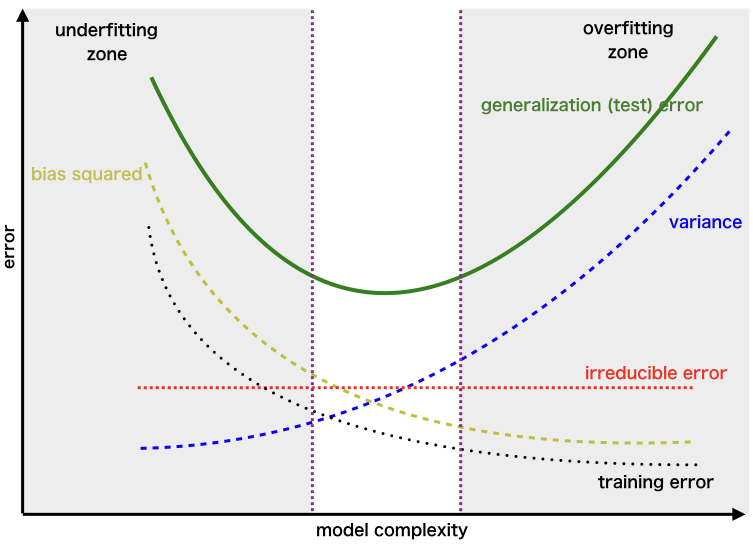

In [3]:
display.Image('bias_variance.png')

The issue of under- vs. overfitting is related to the so-called "Bias-Variance tradeoff", which is an important concept in ML. We will not go into it here, but compare e.g. https://towardsdatascience.com/the-bias-variance-tradeoff-8818f41e39e9 if you are interested.

#### ML with regularization

As indicated by these examples, an essential aspect when doing machine learning is to find and train models that neither over- nor underfit the data, or in other words, that fit the training data well, while generalizing to new data.

The usual strategy is to start with a relatively complex model, i.e. with many features, to avoid underfitting. For example, above we have included 104 features in a linear LS model for the house price data.

Then, in order to reduce overfitting, we *constrain* or *regularize* the model. 

As the prime example, consider what is called *Least Absolute Shrinkage and Selection Operator* (LASSO) regression, which is essentially a regularized version of linear LS regression.

In more detail, for its objective function, Lasso takes the objective function from linear LS, $L(\mathbf{b})$, but adds a regularization term:

\begin{equation}
   \min_{\mathbf{b}} J(\mathbf{b}) = L(\mathbf{b}) + \alpha\ \left|\left|\ \mathbf{b}\ \right| \right|_1 = \frac{1}{2}\sum_{i = 1}^m \left[r_i(\mathbf{b})\right]^2 + \alpha \sum^n_{j = 1} \left| b_j \right|
\end{equation}


Note the following:

- the regularization term is given by the $l_1$-norm (i.e. the sum of absolute values) of the parameter vector. Since it is part of the minimization objective, the algorithm has an incentive to choose as small values for $\mathbf{b}$ as possible. In fact, an important characteristic of Lasso is that it sets some of the elements of $\mathbf{b}$ to zero in order to minimize $J(\mathbf{b})$. In other words, it "eliminates" the least important features from the model.

- $\alpha$ is called a *hyperparameter* (to distinguish it from the "parameters" in $\mathbf{b}$). It controls the amount of regularization that is applied. It is a parameter of the learning algorithm, not of the model, and hence must be constant while training the model. 

With respect to $\alpha$, there is an obvious trade-off:
- the smaller $\alpha$, the less regularization is applied, and hence the closer the model is to linear LS and to potentially overfitting the model;
- in contrast, a large $\alpha$ leads to a lot of features being eliminated by the algorithm, which prevents overfitting; however, *too much regularization* can lead to underfitting the data (e.g. in the extreme case when only one or two features are left).

Finding the "right" hyperparameters (also called *hypertuning*) is one the most important tasks when applying ML. There are established procedures how to go about this search, in particular *(k-fold) cross-validation*.

In the interest of time, we will skip this (very important) topic here and refer to more advanced courses or material on the topic.

Going back to linear LS, the main reason why it is not popular for ML is that it does not have any hyperparameters. In other words, there is no way to constrain linear LS or to choose what degree of regularization to apply to it. 

Put differently, Lasso is inherently more *flexible*, since the algorithm essentially decides by itself how many and what features to use. 

As a side note, there also exist version of regularized linear LS that uses the $l_2$-norm of $\mathbf{b}$ for the regularization parameter (*Ridge regression*) or a combination of $l_1$- and $l_2$-norms (*Elastic Net*). 

Finally, below we run Lasso on our house price example, and compare its prediction performance to linear LS. As you would expect, there is a class **Lasso** in scitkit-learn that lets us do this easily.

In [40]:
from sklearn.linear_model import Lasso

The syntax for training the data is the same as for linear LS. We use a hyperparameter of 0.01 (smaller than the default) and increase the maximum number of iterations (otherwise we would get a warning).

In [41]:
lasso = Lasso(alpha = 0.01, max_iter=100000)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Evaluating its performance, we can see that Lasso does slightly worse on the training set, but considerably better on the test set - exactly what we would like! We can also see that out of the 104 features, only 33 are used, the rest receives parameters equal to zero.

In [42]:
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
## check how many features have a non-zero parameter, i.e. are used
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.90
Test set score: 0.77
Number of features used: 33


As a final remark, note that the Lasso implementation in scikit-learn uses what is called *coordinate descent*, a derivative-free iterative method - the normal equations cannot be applied for regularized linear LS regression!

Again due to time constraints, we will not go into the details here.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'summary'></a>

### Wrapping Up

This lecture has scratched the very surface of machine learning: we have shown its connection to linear LS regression (which is itself a specific application of numerical optimization) and its relation to standard econometric analysis.

Of course, there is a lot in the context of ML that we have not talked about. The following are some examples.

First, regularized linear LS is by no means the only class of ML methods. There are many more, some of them "non-parametric". Well-known examples include decision trees/random forests, neural nets ("deep learning") and various ensemble methods.

Most of them are covered by textbooks on ML (see above) or in ML courses. 

For a formalization of the general idea of all these ML methods, we can follow Mullainathan and Spiess (2017) who summarize ML in the following expression:

\begin{equation}
    \min_{f \in F} L(f(x_i), y_i)\quad s.t.\quad R(f) \le c
\end{equation}

As before, $L$ denotes some cost that we aim to minimize. For variants of linear LS, we can write it as a function of $\mathbf{b}$; more generally, it is a function of $f$ (and the data). 

The minimizer $f$ is itself a particular function (from a class $F$) that maps the feature data (the $x_i$'s) into predicted values for the $y_i$'s. Above, $F$ was essentially the class of *linear* hypothesis functions $h$, while the a particular function $f$ was represented by the parameter vector $\mathbf{b}$.   

$R(f)$ captures the regularizer; in the case of Lasso, for example, $R(f)$ would capture the $l_1$-norm of $\mathbf{b}$.

As a different examples, in the case of decision trees, $F$ would represent the class of trees, and an example for $R(f)$ would be the "depth" of the particular tree (compare Mullainathan and Spiess for some intuition on decision trees).

Second, we have focused here on the case of regression, where the target variable is continuous (e.g. house prices). 

*Classification* (where the target values come from a discrete set, e.g. spam or no spam) is an equally important part of supervised ML.

Moreover, as this indicates, there is also a subfield of *unsupervised* ML. 

Third, as indicated above, we have not discussed how to proceed when tuning the hyperparameters of your model, and more generally to evaluate your model. Cross-Validation and related topics are an essentially part of every specialized course and book on ML.

Finally, why are ML methods actually useful for economists? As stated above, ML is not concerned with causal estimation, and hence may at first glance seem useless for econometric analysis.

It is important to note, however, that while ML is certainly not a substitute for econometrics, it can be understood as a *complement*. That is, we can use ML methods to support econometric analyis.

Consider some examples (from Mullainathan and Spiess - this does not claim to be a complete list!):

- ML can be applied to process "unconventional" data, e.g. to translate satellites images into meaningful measures that can be used as input in econometric analysis. It can also be used to improve more standard measures, like democracy indices (compare the work by ifo researcher Klaus Gründler: https://www.wiwi.uni-wuerzburg.de/lehrstuhl/vwl4/data/svmdi-dataset/). 

- In estimation problems, there may be (implicit) prediction components. For example, the first stage of an IV approach is essentially a prediction problem. More generally, ML can be used to create counterfactuals to be used in estimation. Moreover, there is a large literature on the estimation of "heterogeneous treatment effects" using ML as "a means to an end" (compare, among others, the work by Susan Athey). 

- Finally, ML can be directly applied in public policy. An example is the famous "bail decision" problem - should a defendant be released on bail or not? - which could be "outsourced" to an ML algorithm rather than made by a judge. 